https://www.transtats.bts.gov/Fields.asp?Table_ID=236

In [1]:
from __future__ import division #, print_function # Imports from __future__ since we're running Python 2

In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from flights_delay.feature_processing import FlightDelayFeatureProcessing
from helpers.outliers import MyOutliers
from helpers.feature_engineering import makeBinaryClassification, getUniqueValuesPerFeature
from sklearn.model_selection import train_test_split
from helpers.plot_helper import plotDistsPerClass, plotBothDists
from flights_delay.feature_prev_delays import FeaturePrevDelays
from flights_delay.feature_airline_delays import FeatureAirlineDelays
from helpers.my_one_hot_encoder import MyOneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.dummy import DummyClassifier
from helpers.feature_engineering import dateStrToDayYear, getMappingOfSimilarCategoricalColumns, \
    compareSimilarCategoricalColumns 
from helpers.my_one_hot_encoder import MyOneHotEncoder
from helpers.py_helpers import is_number
from scipy.stats import skew, kurtosis
from helpers.outliers import MyOutliers
from sklearn.preprocessing import StandardScaler
from helpers.plot_helper import scatter_2d_label
from sklearn.decomposition import PCA # Import the PCA module
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from helpers.performance_issues import subsample_keeping_class_proportions
from sklearn.metrics import f1_score, precision_score
from sklearn.manifold import Isomap
from helpers.performance_issues import subsample_keeping_class_proportions, rbfPCAkernel
from flights_delay.feature_processing import FlightDelayFeatureProcessing
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from matplotlib.colors import ListedColormap
from flights_delay.flight_delay_scoring import printFlightDelayScores, getFlightDelayScores
from helpers.my_cross_validation import MyCrossValidation
from sklearn.metrics import log_loss
from helpers.performance_issues import processSeparately
from helpers.plot_helper import scatter_2d_label, plotGPoptFunction, plotGPoptConvergence
from flights_delay.flight_delay_scoring import getScore_onKFold_callback, scoreWithDimReduction
from flights_delay.dataset import getRbfKernelPCADimReducedDataset
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
from time import time, sleep

In [4]:
plt.style.use('ggplot')

In [5]:
random_state = 0 # Ensure reproducible results

In [6]:
data_relative_path = '../Data'

In [7]:
target_col = 'IS_DELAYED'

In [8]:
n_jobs = 4

# Flying to New York City - Classifying

In [9]:
path_data = os.path.realpath(os.path.join(os.getcwd(), data_relative_path, 'train_data_v2_engineered.csv'))
assert os.path.isfile(path_data)
path_data

'/home/student/pligor.george@gmail.com/msc_Artificial_Intelligence/dme_Data_Mining/dmedatarats/Data/train_data_v2_engineered.csv'

In [10]:
df = pd.read_csv(path_data, delimiter = ',', header=0)
df.shape

(31186, 43)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31186 entries, 0 to 31185
Data columns (total 43 columns):
QUARTER               31186 non-null int64
MONTH                 31186 non-null int64
DAY_OF_MONTH          31186 non-null int64
DAY_OF_WEEK           31186 non-null int64
DEP_TIME              31186 non-null float64
DEP_DELAY             31186 non-null float64
DEP_DELAY_NEW         31186 non-null float64
DEP_DEL15             31186 non-null float64
DEP_DELAY_GROUP       31186 non-null float64
CRS_ELAPSED_TIME      31186 non-null float64
PREV_DELAYS_30        31186 non-null float64
PREV_DELAYS_60        31186 non-null float64
PREV_DELAYS_120       31186 non-null float64
PREV_DELAYS_180       31186 non-null float64
PREV_DELAYS_360       31186 non-null float64
PREV_DELAYS_720       31186 non-null float64
AIRLINE_DELAYS_30     31186 non-null float64
AIRLINE_DELAYS_60     31186 non-null float64
AIRLINE_DELAYS_120    31186 non-null float64
AIRLINE_DELAYS_180    31186 non-null float64

In [12]:
df.sample(10, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,CRS_ELAPSED_TIME,...,ORIGIN_3,ORIGIN_4,ORIGIN_5,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4,DEST_5,IS_DELAYED
4696,0,1,0,1,1358.878788,-6.0,0.0,0.0,-1.0,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
22712,0,0,0,0,667.878788,68.0,68.0,1.0,4.0,398.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True
959,1,1,0,0,1388.878788,9.0,9.0,0.0,0.0,133.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
3668,1,1,0,0,1170.878788,81.0,81.0,1.0,5.0,137.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
24321,1,1,0,0,400.878788,-9.0,0.0,0.0,-1.0,66.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False
2887,0,0,0,0,1194.878788,7.0,7.0,0.0,0.0,173.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
12034,0,0,1,0,1859.878788,70.0,70.0,1.0,4.0,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
13019,0,0,1,0,955.878788,131.0,131.0,1.0,8.0,131.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
15102,0,0,0,0,390.878788,-4.0,0.0,0.0,-1.0,130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
15423,0,0,1,0,1271.878788,82.0,82.0,1.0,5.0,192.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True


In [13]:
XX = df.drop(labels=[target_col], axis=1)
yy = df[target_col]
XX.shape, yy.shape

((31186, 42), (31186,))

In [14]:
columns_one_hot_encoded = np.array([col for col in df.columns if is_number(col[-1])])
columns_not_one_hot = np.array([col for col in df.columns if not is_number(col[-1])])

In [15]:
df[columns_not_one_hot].describe()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DELAY_GROUP,CRS_ELAPSED_TIME
count,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000
mean,0.268903,0.285449,0.173988,0.328898,1070.573074,19.281953,21.085840,0.751812,238.534631
std,0.443396,0.451635,0.379106,0.469820,506.387802,32.605802,31.302126,2.237086,111.624021
min,0.000000,0.000000,0.000000,0.000000,178.878788,-20.000000,0.000000,-2.000000,59.000000
25%,0.000000,0.000000,0.000000,0.000000,605.878788,-3.000000,0.000000,-1.000000,140.000000
50%,0.000000,0.000000,0.000000,0.000000,1078.878788,2.000000,2.000000,0.000000,177.000000
75%,1.000000,1.000000,0.000000,1.000000,1482.628788,34.000000,34.000000,2.000000,341.000000
max,1.000000,1.000000,1.000000,1.000000,2297.878788,132.000000,132.000000,8.000000,468.000000


### Dummy Classifier

In [16]:
dc = DummyClassifier(random_state=random_state).fit(XX, yy)
dc.score(XX, yy)

0.49785160007695761

In [17]:
dummy_preds = dc.predict(XX)
printFlightDelayScores(y_true=yy, y_pred=dummy_preds)

precision score for delayed flights: 0.498662420382
f1 score for both classes: [ 0.49571714  0.49996807]
f1 score for is_delayed true class: 0.499968069481
f1 score with weighted average: 0.497846011409
f1 score with unweighted average: 0.497842603685


In [18]:
log_loss(y_true = yy, y_pred = dc.predict_proba(XX))

17.343591302004143

## Naive Bayes

In [36]:
clf = GaussianNB()

In [40]:
cv = MyCrossValidation(n_folds=10, random_state=random_state)

In [42]:
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
scores

precision_score            0.847233
f1_score_nondelayed        0.809183
f1_score_delayed           0.779077
f1_score_weighted_avg      0.794136
f1_score_unweighted_avg    0.794130
log_loss                   2.740051
accuracy_score             0.795261
dtype: float64

## Quadratic Discriminant Classifier

In [43]:
clf = QuadraticDiscriminantAnalysis()

In [44]:
cv = MyCrossValidation(n_folds=10, random_state=random_state)

In [45]:
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
scores

/home/student/anaconda2/envs/dme/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


precision_score            0.837377
f1_score_nondelayed        0.798841
f1_score_delayed           0.764298
f1_score_weighted_avg      0.781585
f1_score_unweighted_avg    0.781569
log_loss                   1.850568
accuracy_score             0.783012
dtype: float64

## K-Neighbors Classifier

In [52]:
%%time
clf = KNeighborsClassifier(n_neighbors=3, n_jobs=n_jobs)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.793938
f1_score_nondelayed        0.781561
f1_score_delayed           0.768018
f1_score_weighted_avg      0.774810
f1_score_unweighted_avg    0.774789
log_loss                   2.998314
accuracy_score             0.775027
dtype: float64
CPU times: user 17.6 s, sys: 48 ms, total: 17.7 s
Wall time: 8.77 s


In [61]:
def gpOptimization(n_jobs=n_jobs, n_folds=10):  # using all the features is too slow with any kind of neighbor
    
    def objective(params): # Here we define the metric we want to minimise
        (n_neighbors, ) = params
        print "current neighbors: {}".format(n_neighbors)
        start = time()

        clf = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=n_jobs)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)

        scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
        score = scores['accuracy_score']
        print "current accuracy score: {}".format(score)
        print "time elapsed: {}".format(time() - start)
        print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return -score
    
    neighborsSpace = Integer(1, 100)
    space  = [neighborsSpace]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [62]:
res_gp = gpOptimization()

current neighbors: 45
current accuracy score: 0.799589976064
time elapsed: 11.4473598003

current neighbors: 48
current accuracy score: 0.800231176379
time elapsed: 12.320554018

current neighbors: 65
current accuracy score: 0.796896321887
time elapsed: 10.8142950535

current neighbors: 68
current accuracy score: 0.795966577831
time elapsed: 10.7314670086

current neighbors: 68
current accuracy score: 0.795966577831
time elapsed: 11.099572897

current neighbors: 1
current accuracy score: 0.74337848618
time elapsed: 7.12966108322

current neighbors: 100
current accuracy score: 0.790483269892
time elapsed: 11.1473920345

current neighbors: 33
current accuracy score: 0.801513885493
time elapsed: 9.73603200912

current neighbors: 85
current accuracy score: 0.793754062964
time elapsed: 10.8607058525

current neighbors: 40
current accuracy score: 0.800231248359
time elapsed: 11.058275938

current neighbors: 29
current accuracy score: 0.801257372462
time elapsed: 10.8301861286

current neighb

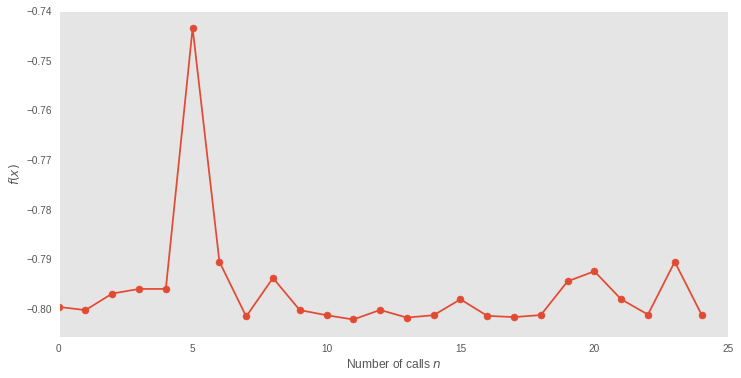

In [63]:
plotGPoptFunction(res_gp)
plt.show()

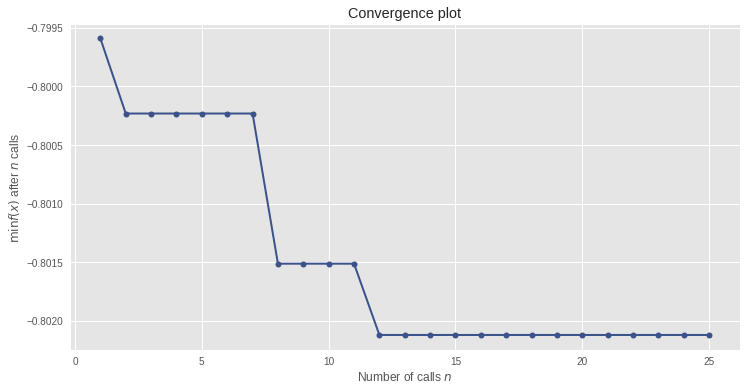

In [64]:
plotGPoptConvergence(res_gp)
plt.show()

In [66]:
(best_n_neighbors, ) = res_gp.x
best_n_neighbors

26

In [67]:
%%time
clf = KNeighborsClassifier(n_neighbors=best_n_neighbors, n_jobs=n_jobs)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.875145
f1_score_nondelayed        0.819374
f1_score_delayed           0.781170
f1_score_weighted_avg      0.800267
f1_score_unweighted_avg    0.800272
log_loss                   0.462645
accuracy_score             0.802123
dtype: float64
CPU times: user 21.2 s, sys: 52 ms, total: 21.3 s
Wall time: 8.13 s


## Linear Support Vector Classifier

In [19]:
%%time
clf = SVC(kernel='linear', probability=True)
cv = MyCrossValidation(n_folds=2, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.853475
f1_score_nondelayed        0.821916
f1_score_delayed           0.800395
f1_score_weighted_avg      0.811141
f1_score_unweighted_avg    0.811155
log_loss                   0.415082
accuracy_score             0.811775
dtype: float64
CPU times: user 2h 46min 13s, sys: 2.33 s, total: 2h 46min 15s
Wall time: 2h 46min 17s


In [24]:
def gpOptimization(n_jobs=n_jobs, n_folds=2):  # using all the features is too slow with any kind of neighbor
    
    def objective(params): # Here we define the metric we want to minimise
        (CC, ) = params
        print "current C: {}".format(CC)
        start = time()

        clf = SVC(kernel='linear', probability=False, C=CC)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)
        
        def onKFold_callback(cls):
            def score_onKFold(X_train, y_train, X_valid, y_valid, i):
                return pd.Series(data = cls.fit(X_train, y_train).score(X_valid, y_valid),
                                 name="accuracy_score").to_frame()
            return score_onKFold
        
        scores = cv.onEachKFold(XX, yy, onKFold_callback(clf))
        score = scores['accuracy_score']
        print "current accuracy score: {}".format(score)
        print "time elapsed: {}".format(time() - start)
        print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return -score
    
    C_space = Real(1e-4, 1e1, prior='log-uniform')
    space  = [C_space]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=10, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=1,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [ ]:
res_gp = gpOptimization()

current C: 0.0554711947159


In [ ]:
plotGPoptFunction(res_gp)
plt.show()

In [ ]:
plotGPoptConvergence(res_gp)
plt.show()

In [ ]:
(bestC, ) = res_gp.x
bestC

In [ ]:
%%time
clf = SVC(kernel='linear', probability=True, C=bestC)
cv = MyCrossValidation(n_folds=2, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

## Decision Tree Classifier

In [22]:
%%time
clf = DecisionTreeClassifier(max_depth=None)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.740021
f1_score_nondelayed        0.740521
f1_score_delayed           0.744467
f1_score_weighted_avg      0.742528
f1_score_unweighted_avg    0.742494
log_loss                   8.886615
accuracy_score             0.742545
dtype: float64
CPU times: user 3.13 s, sys: 8 ms, total: 3.14 s
Wall time: 3.14 s


In [26]:
def gpOptimization(n_jobs=n_jobs, n_folds=10):
    
    def objective(params): # Here we define the metric we want to minimise
        (max_depth, ) = params
        print "current depth: {}".format(max_depth)
        start = time()

        clf = DecisionTreeClassifier(max_depth=max_depth)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)

        scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
        score = scores['accuracy_score']
        print "current accuracy score: {}".format(score)
        print "time elapsed: {}".format(time() - start)
        print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return -score
    
    max_depth_space = Integer(1, 100)
    space  = [max_depth_space]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [27]:
res_gp = gpOptimization()

current depth: 45
current accuracy score: 0.743153726226
time elapsed: 3.19104409218

current depth: 48
current accuracy score: 0.743538485489
time elapsed: 3.21846318245

current depth: 65
current accuracy score: 0.744179829763
time elapsed: 3.35046100616

current depth: 68
current accuracy score: 0.744564732985
time elapsed: 3.29130387306

current depth: 68
current accuracy score: 0.744115624385
time elapsed: 3.14930319786

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.536122083664



/home/student/anaconda2/envs/dme/lib/python2.7/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.545443058014

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.526083946228

current depth: 100
current accuracy score: 0.743346218967
time elapsed: 3.35515189171

current depth: 10
current accuracy score: 0.80132135162
time elapsed: 2.08828878403

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.516134977341

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.596716880798

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.506857872009

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.536137104034

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.532940149307

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.521903991699

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.505615949631

current depth: 1
current accuracy score: 0.81241593609

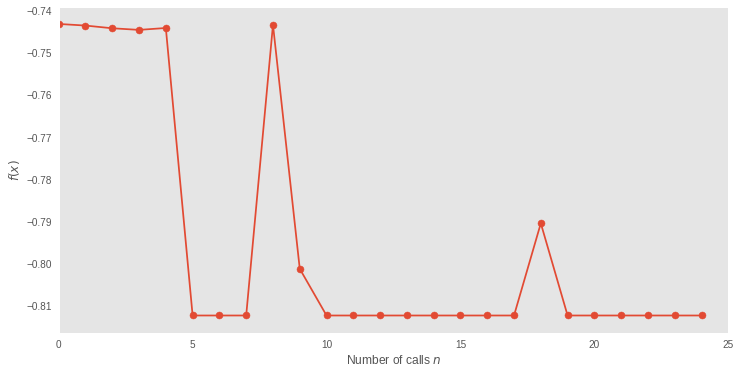

In [28]:
plotGPoptFunction(res_gp)
plt.show()

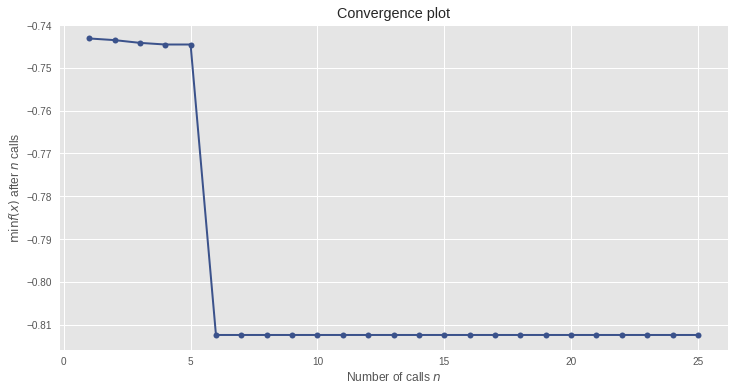

In [29]:
plotGPoptConvergence(res_gp)
plt.show()

In [31]:
(best_max_depth, ) = res_gp.x
best_max_depth

1

In [32]:
%%time
clf = DecisionTreeClassifier(max_depth=best_max_depth)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.900854
f1_score_nondelayed        0.830753
f1_score_delayed           0.789529
f1_score_weighted_avg      0.810134
f1_score_unweighted_avg    0.810141
log_loss                   0.465058
accuracy_score             0.812416
dtype: float64
CPU times: user 496 ms, sys: 0 ns, total: 496 ms
Wall time: 496 ms


### log loss

In [48]:
def gpOptimization(n_jobs=1, n_folds=10):
    
    def objective(params): # Here we define the metric we want to minimise
        (max_depth, ) = params
        print "current depth: {}".format(max_depth)
        start = time()

        clf = DecisionTreeClassifier(max_depth=max_depth)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)

        scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
        score = scores['log_loss']
        print "current log loss: {}".format(score)
        print "time elapsed: {}".format(time() - start)
        print

        return score
    
    max_depth_space = Integer(1, 100)
    space  = [max_depth_space]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [49]:
res_gp = gpOptimization()

current depth: 45
current log loss: 8.90646201474
time elapsed: 3.14535593987

current depth: 48
current log loss: 8.83005391395
time elapsed: 3.22690916061

current depth: 65
current log loss: 8.84334019734
time elapsed: 3.2940518856

current depth: 68
current log loss: 8.88217487785
time elapsed: 3.07227301598

current depth: 68
current log loss: 8.86767094031
time elapsed: 3.39970684052

current depth: 54
current log loss: 8.82996452778
time elapsed: 3.13702487946

current depth: 53
current log loss: 8.89095569809
time elapsed: 3.35341310501

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.544570207596

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.964903831482

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.934834003448

current depth: 7
current log loss: 0.48531578548
time elapsed: 1.93286514282

current depth: 3
current log loss: 0.414045178683
time elapsed: 1.00506591797

current depth: 4
current log loss: 0.407389865121
t

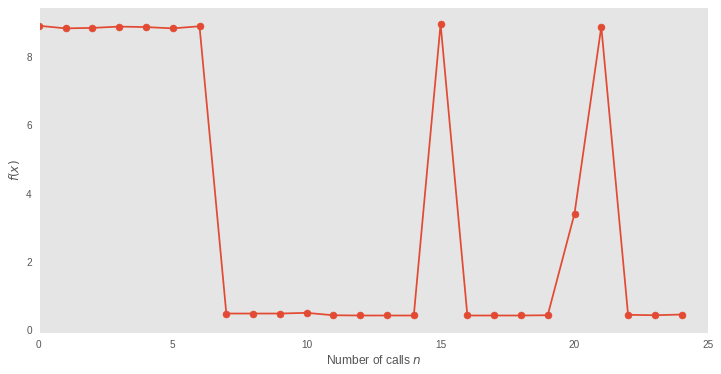

In [50]:
plotGPoptFunction(res_gp)
plt.show()

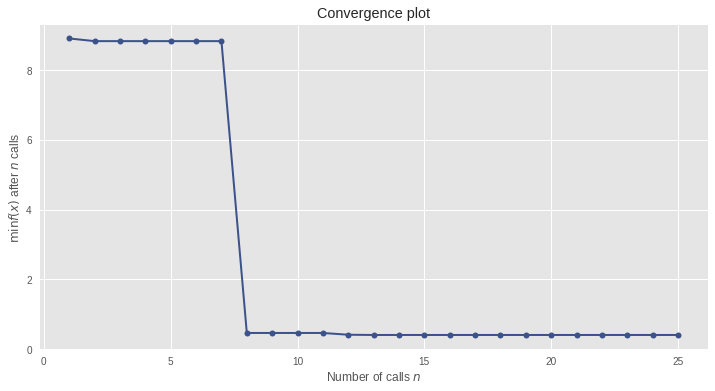

In [51]:
plotGPoptConvergence(res_gp)
plt.show()

In [52]:
(best_max_depth, ) = res_gp.x
best_max_depth

4

In [53]:
%%time
clf = DecisionTreeClassifier(max_depth=best_max_depth)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.884108
f1_score_nondelayed        0.831145
f1_score_delayed           0.799404
f1_score_weighted_avg      0.815279
f1_score_unweighted_avg    0.815275
log_loss                   0.407390
accuracy_score             0.816681
dtype: float64
CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 1.41 s
